In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import familiarization as fam

# data_9 = fam.load_data("data/capture20110817.binetflow.txt")
data = fam.load_data("data/capture20110818.binetflow.txt")
# data_11 = fam.load_data("data/capture20110818-2.binetflow.txt")
# data_12 = fam.load_data("data/capture20110819.binetflow.txt")
infected_hosts_addr = ["147.32.84.165","147.32.84.191","147.32.84.192","147.32.84.193","147.32.84.204","147.32.84.205","147.32.84.206","147.32.84.207","147.32.84.208","147.32.84.209"]

In [2]:
pdata = fam.pre_process(data)
pdata.head()

,StartTime,Duration,Protocol,SourceAddress,SourcePort,Direction,DestinationAddress,DestinationPort,TotalPackets,TotalBytes,SourceBytes,Label,Infected
407,2011/08/18 10:19:15.693956,3587.569824,TCP,147.32.84.164,54784,<?>,74.125.232.215,443,3049,978731,245317,flow=From-Normal-V51-Grill,0
697,2011/08/18 10:19:18.143576,198.072739,TCP,147.32.84.164,56165,<?>,74.125.232.197,80,14,924,462,flow=From-Normal-V51-Grill,0
717,2011/08/18 10:19:18.303590,197.928329,TCP,147.32.84.164,57965,<?>,209.85.149.138,80,14,924,462,flow=From-Normal-V51-Grill,0
896,2011/08/18 10:19:19.838272,0.000399,UDP,147.32.84.170,45807,<->,147.32.80.9,53,2,400,74,flow=From-Normal-V51-Stribrek,0
897,2011/08/18 10:19:19.839123,0.000400,UDP,147.32.84.170,35380,<->,147.32.80.9,53,2,400,74,flow=From-Normal-V51-Stribrek,0


In [3]:
infected_hosts = pdata.loc[pdata["Infected"] == 1]
non_infected_hosts = pdata.loc[pdata["Infected"] == 0]
print(len(pdata),len(infected_hosts), len(non_infected_hosts))
infected_hosts.head()

122199 106352 15847


,StartTime,Duration,Protocol,SourceAddress,SourcePort,Direction,DestinationAddress,DestinationPort,TotalPackets,TotalBytes,SourceBytes,Label,Infected
90529,2011/08/18 10:37:58.448307,0.000342,UDP,147.32.84.165,1025,<->,147.32.80.9,53,2,203,64,flow=From-Botnet-V51-1-UDP-DNS,1
90715,2011/08/18 10:38:00.695278,0.010278,UDP,147.32.84.165,1025,<->,147.32.80.9,53,2,590,87,flow=From-Botnet-V51-1-UDP-DNS,1
90716,2011/08/18 10:38:00.706560,0.043726,TCP,147.32.84.165,1027,->,74.125.232.206,80,7,882,629,flow=From-Botnet-V51-1-TCP-HTTP-Google-Net-Est...,1
90872,2011/08/18 10:38:03.255934,0.010256,UDP,147.32.84.165,1025,<->,147.32.80.9,53,2,479,76,flow=From-Botnet-V51-1-UDP-DNS,1
90875,2011/08/18 10:38:03.267222,581.516663,UDP,147.32.84.165,123,->,65.55.56.40,123,4,360,360,flow=From-Botnet-V51-1-UDP-Attempt,1


In [4]:
infected_hosts.describe()

,Duration,TotalPackets,TotalBytes,SourceBytes,Infected
count,106352.000000,106352.000000,1.063520e+05,1.063520e+05,106352.0
mean,90.825592,30.315330,2.712966e+04,2.712120e+04,1.0
std,292.015024,1741.181013,1.388200e+06,1.388200e+06,0.0
min,0.000000,1.000000,6.000000e+01,6.000000e+01,1.0
25%,0.000000,1.000000,1.066000e+03,1.066000e+03,1.0
50%,0.000000,1.000000,1.066000e+03,1.066000e+03,1.0
75%,0.000000,1.000000,1.066000e+03,1.066000e+03,1.0
max,3594.721436,176254.000000,1.387386e+08,1.387386e+08,1.0


In [5]:
non_infected_hosts.describe()

,Duration,TotalPackets,TotalBytes,SourceBytes,Infected
count,15847.000000,15847.000000,1.584700e+04,1.584700e+04,15847.0
mean,46.585670,35.749164,2.719936e+04,1.660341e+03,0.0
std,301.233657,506.146679,4.707149e+05,1.838861e+04,0.0
min,0.000000,1.000000,6.600000e+01,0.000000e+00,0.0
25%,0.000318,2.000000,2.440000e+02,7.400000e+01,0.0
50%,0.000480,2.000000,4.000000e+02,8.100000e+01,0.0
75%,0.112268,6.000000,4.780000e+02,2.720000e+02,0.0
max,3599.957031,32630.000000,3.048162e+07,1.136051e+06,0.0


In [6]:
# Compare statistics for infected and non-infected hosts
## Average Duration
duration_infected = np.mean(infected_hosts["Duration"])
duration_non_infected = np.mean(non_infected_hosts["Duration"])

## Protocol
protocols_infected = infected_hosts.Protocol.value_counts(normalize=True)
protocols_non_infected = non_infected_hosts.Protocol.value_counts(normalize=True)

## Average TotalPackets
packets_infected = np.mean(infected_hosts.TotalPackets)
packets_non_infected = np.mean(non_infected_hosts.TotalPackets)

## Average TotalBytes
bytes_infected = np.mean(infected_hosts.TotalBytes)
bytes_non_infected = np.mean(non_infected_hosts.TotalBytes)

## Average SourceBytes
source_bytes_infected = np.mean(infected_hosts.SourceBytes)
source_bytes_non_infected = np.mean(non_infected_hosts.SourceBytes)

print("Infected hosts")
print(" Duration:", duration_infected)
print(" Protocols: \n",protocols_infected)
print(" Average Packets",packets_infected)
print(" Average Bytes",bytes_infected)
print(" Source Bytes",source_bytes_infected)

print("\n")
print("Non-Infected hosts")
print(" Duration:", duration_non_infected)
print(" Protocols: \n",protocols_non_infected)
print(" Average Packets",packets_non_infected)
print(" Average Bytes",bytes_non_infected)
print(" Source Bytes",source_bytes_non_infected)

Infected hosts
 Duration: 90.82559153096324
 Protocols: 
 ICMP    0.996474
UDP     0.002755
TCP     0.000771
Name: Protocol, dtype: float64
 Average Packets 30.315330224161276
 Average Bytes 27129.65718557244
 Source Bytes 27121.20417105461


Non-Infected hosts
 Duration: 46.58566988862245
 Protocols: 
 UDP     0.617152
TCP     0.337162
ICMP    0.044993
ARP     0.000694
Name: Protocol, dtype: float64
 Average Packets 35.74916387959866
 Average Bytes 27199.363854357292
 Source Bytes 1660.3409478134663


The statistics are clear in the differences between the infected and non-infected hosts:
- The duration for flows from infected hosts is about twice the time as for non-infected hosts
- Almost all flow from the infected hosts use the ICMP protocol, while UDP and TCP are most popular for non-infected hosts
- The total number of packets and bytes do not differ much between both hosts
- The bytes sent by infected hosts are a lot higher for infected hosts

The two features that stand out most are the ICMP protocol and Duration/SourceBytes

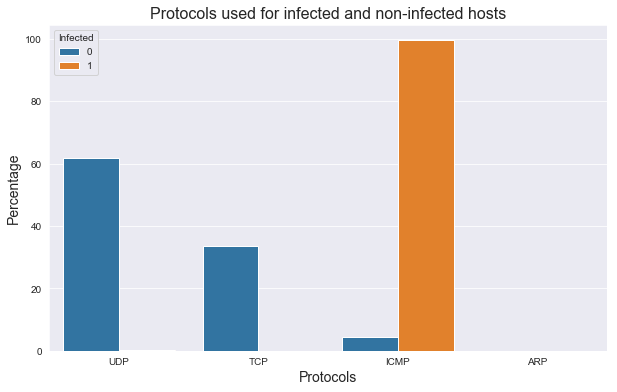

In [29]:
# Visualize protocols used
protocol_grouped = pdata.groupby('Infected')['Protocol'].value_counts(normalize=True)
protocol_grouped = protocol_grouped.mul(100)
protocol_grouped = protocol_grouped.rename('percent').reset_index()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x='Protocol',y='percent',hue='Infected',data=protocol_grouped)
ax.set_title("Protocols used for infected and non-infected hosts",size=16)
ax.set_ylabel("Percentage",size=14)
ax.set_xlabel("Protocols",size=14)
plt.show()

In [55]:
X = np.array(infected_hosts["Duration"]).reshape(-1,1)
est = KBinsDiscretizer(n_bins=25, strategy='quantile')
est.fit(X)
Xt = est.transform(X)
binsedges = est.bin_edges_[0]
pd.cut(np.array(infected_hosts["Duration"]), bins=binsedges).value_counts()

/Users/lennartoverdevest/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


(0.0, 882.223]         1605
(882.223, 986.877]     4254
(986.877, 3594.721]    4255
dtype: int64

In [61]:
X = np.array(infected_hosts["SourceBytes"]).reshape(-1,1)
est = KBinsDiscretizer(n_bins=50, strategy='quantile')
est.fit(X)
Xt = est.transform(X)
binsedges = est.bin_edges_[0]
pd.cut(np.array(infected_hosts["SourceBytes"]), bins=binsedges).value_counts()

/Users/lennartoverdevest/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


(60.0, 1066.0]            96460
(1066.0, 2132.0]           4677
(2132.0, 10660.0]          1051
(10660.0, 28782.0]         2028
(28782.0, 138738569.0]     2127
dtype: int64